In [170]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_recommenders as tfrs
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
ratings = pd.read_csv('../backend/datasets/ratings.csv')
keywords_data = pd.read_csv('../backend/datasets/keywords.csv', delimiter=',')

In [3]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [4]:
keywords_data.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [5]:
ratings.describe()

,userId,movieId,rating,timestamp
count,2.602429e+07,2.602429e+07,2.602429e+07,2.602429e+07
mean,1.350371e+05,1.584911e+04,3.528090e+00,1.171258e+09
std,7.817620e+04,3.108526e+04,1.065443e+00,2.052889e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08
25%,6.716400e+04,1.073000e+03,3.000000e+00,9.907545e+08
50%,1.351630e+05,2.583000e+03,3.500000e+00,1.151716e+09
75%,2.026930e+05,6.503000e+03,4.000000e+00,1.357578e+09
max,2.708960e+05,1.762750e+05,5.000000e+00,1.501830e+09


In [6]:
keywords_data.describe()

,id
count,46419.000000
mean,109769.951873
std,113045.780256
min,2.000000
25%,26810.500000
50%,61198.000000
75%,159908.500000
max,469172.000000


In [7]:
ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [8]:
keywords_data.isnull().sum()

id          0
keywords    0
dtype: int64

## DATA PREPROCESSING

In [9]:
ratings = ratings.drop_duplicates()

In [10]:
ratings

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556
...,...,...,...,...
26024284,270896,58559,5.0,1257031564
26024285,270896,60069,5.0,1257032032
26024286,270896,63082,4.5,1257031764
26024287,270896,64957,4.5,1257033990


In [11]:
print(keywords_data.shape)
keywords_data = keywords_data.drop_duplicates(subset=['id'])
print(keywords_data.shape)

(46419, 2)
(45432, 2)


In [12]:
keywords_data

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."
...,...,...
46414,439050,"[{'id': 10703, 'name': 'tragic love'}]"
46415,111109,"[{'id': 2679, 'name': 'artist'}, {'id': 14531,..."
46416,67758,[]
46417,227506,[]


In [13]:
keywords_data.reset_index(drop=True, inplace=True)

In [14]:
keywords_data

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."
...,...,...
45427,439050,"[{'id': 10703, 'name': 'tragic love'}]"
45428,111109,"[{'id': 2679, 'name': 'artist'}, {'id': 14531,..."
45429,67758,[]
45430,227506,[]


In [15]:
keywords_data.describe()

,id
count,45432.000000
mean,108368.766750
std,112472.571213
min,2.000000
25%,26459.250000
50%,59995.500000
75%,157350.250000
max,469172.000000


In [16]:
ratings.describe()

,userId,movieId,rating,timestamp
count,2.602429e+07,2.602429e+07,2.602429e+07,2.602429e+07
mean,1.350371e+05,1.584911e+04,3.528090e+00,1.171258e+09
std,7.817620e+04,3.108526e+04,1.065443e+00,2.052889e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08
25%,6.716400e+04,1.073000e+03,3.000000e+00,9.907545e+08
50%,1.351630e+05,2.583000e+03,3.500000e+00,1.151716e+09
75%,2.026930e+05,6.503000e+03,4.000000e+00,1.357578e+09
max,2.708960e+05,1.762750e+05,5.000000e+00,1.501830e+09


In [17]:
ratings['movieId'].max()

np.int64(176275)

In [18]:
keywords_data['id'].nunique()

45432

In [19]:
ratings['movieId'].nunique()

45115

In [20]:
#NOTE: total no of keywords column > total no of movies

### EXPLORING KEYWORDS DATA
- parsing keywords directly to json causing error because keys(id and name) are not properly nested in side double quote

In [21]:
keywords_data.shape

(45432, 2)

In [22]:
keywords_data.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [23]:
keywords_data['keywords'].iloc[0]

"[{'id': 931, 'name': 'jealousy'}, {'id': 4290, 'name': 'toy'}, {'id': 5202, 'name': 'boy'}, {'id': 6054, 'name': 'friendship'}, {'id': 9713, 'name': 'friends'}, {'id': 9823, 'name': 'rivalry'}, {'id': 165503, 'name': 'boy next door'}, {'id': 170722, 'name': 'new toy'}, {'id': 187065, 'name': 'toy comes to life'}]"

In [24]:
# json.loads(keywords_data['keywords'].iloc[1].replace("\'id\'",'"id"').replace("\'name\'", "name"))

In [25]:
data = keywords_data['keywords'].iloc[17]

In [26]:
print(data.replace('\"s',"\'s"))

[{'id': 612, 'name': 'hotel'}, {'id': 613, 'name': "new year's eve"}, {'id': 616, 'name': 'witch'}, {'id': 622, 'name': 'bet'}, {'id': 922, 'name': 'hotel room'}, {'id': 2700, 'name': 'sperm'}, {'id': 12670, 'name': 'los angeles'}, {'id': 160488, 'name': 'hoodlum'}, {'id': 187056, 'name': 'woman director'}, {'id': 198129, 'name': 'episode film'}]


In [27]:
# find currupted data before processing and after processing

# data = keywords_data['keywords'].iloc[1].replace("\'", '\"')

def convert_to_json(data):
    return data.replace("\'", '\"')

def is_currupt(data):
    curpt = False
    try:
        json.loads(data)
    except:
        curpt = True
    return curpt

In [28]:
keywords_data['keywords'].iloc[1]

'[{\'id\': 10090, \'name\': \'board game\'}, {\'id\': 10941, \'name\': \'disappearance\'}, {\'id\': 15101, \'name\': "based on children\'s book"}, {\'id\': 33467, \'name\': \'new home\'}, {\'id\': 158086, \'name\': \'recluse\'}, {\'id\': 158091, \'name\': \'giant insect\'}]'

In [29]:
# json.loads(keywords_data['keywords'].iloc[1].replace("\'s ", " ")).replace("\'", '\"')
# giving error

In [30]:
keywords_data['keywords'] = keywords_data['keywords'].apply(convert_to_json)

In [31]:
keywords_data['keywords'].iloc[1]

'[{"id": 10090, "name": "board game"}, {"id": 10941, "name": "disappearance"}, {"id": 15101, "name": "based on children"s book"}, {"id": 33467, "name": "new home"}, {"id": 158086, "name": "recluse"}, {"id": 158091, "name": "giant insect"}]'

In [32]:
keywords_data['keywords'].iloc[3]

'[{"id": 818, "name": "based on novel"}, {"id": 10131, "name": "interracial relationship"}, {"id": 14768, "name": "single mother"}, {"id": 15160, "name": "divorce"}, {"id": 33455, "name": "chick flick"}]'

In [33]:
keywords_data['currupted'] = keywords_data['keywords'].apply(is_currupt)

In [34]:
keywords_data['currupted']

0        False
1         True
2        False
3        False
4        False
         ...  
45427    False
45428    False
45429    False
45430    False
45431    False
Name: currupted, Length: 45432, dtype: bool

### PROCESSING KEYWORDS DATA

In [35]:
def find_currupted_index(keywords_data):
    list_of_currupted_rows = []
    index = 0
    for data in keywords_data['currupted']:
        if data == True:
            list_of_currupted_rows.append(index)
        index += 1
    return list_of_currupted_rows

In [36]:
keywords_data.shape

(45432, 3)

In [37]:
new_keywords_df = pd.DataFrame(keywords_data)

In [38]:
new_keywords_df

,id,keywords,currupted
0,862,"[{""id"": 931, ""name"": ""jealousy""}, {""id"": 4290,...",False
1,8844,"[{""id"": 10090, ""name"": ""board game""}, {""id"": 1...",True
2,15602,"[{""id"": 1495, ""name"": ""fishing""}, {""id"": 12392...",False
3,31357,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",False
4,11862,"[{""id"": 1009, ""name"": ""baby""}, {""id"": 1599, ""n...",False
...,...,...,...
45427,439050,"[{""id"": 10703, ""name"": ""tragic love""}]",False
45428,111109,"[{""id"": 2679, ""name"": ""artist""}, {""id"": 14531,...",False
45429,67758,[],False
45430,227506,[],False


In [39]:
new_keywords_df.reset_index(drop=True, inplace=True)

In [40]:
new_keywords_df

,id,keywords,currupted
0,862,"[{""id"": 931, ""name"": ""jealousy""}, {""id"": 4290,...",False
1,8844,"[{""id"": 10090, ""name"": ""board game""}, {""id"": 1...",True
2,15602,"[{""id"": 1495, ""name"": ""fishing""}, {""id"": 12392...",False
3,31357,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",False
4,11862,"[{""id"": 1009, ""name"": ""baby""}, {""id"": 1599, ""n...",False
...,...,...,...
45427,439050,"[{""id"": 10703, ""name"": ""tragic love""}]",False
45428,111109,"[{""id"": 2679, ""name"": ""artist""}, {""id"": 14531,...",False
45429,67758,[],False
45430,227506,[],False


In [41]:
new_keywords_df.shape

(45432, 3)

In [42]:
new_keywords_df.head()

,id,keywords,currupted
0,862,"[{""id"": 931, ""name"": ""jealousy""}, {""id"": 4290,...",False
1,8844,"[{""id"": 10090, ""name"": ""board game""}, {""id"": 1...",True
2,15602,"[{""id"": 1495, ""name"": ""fishing""}, {""id"": 12392...",False
3,31357,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",False
4,11862,"[{""id"": 1009, ""name"": ""baby""}, {""id"": 1599, ""n...",False


In [43]:
list_of_currupted_rows = find_currupted_index(new_keywords_df)

In [44]:
# print(list_of_currupted_rows)

In [45]:
len(list_of_currupted_rows)

628

In [46]:
# new_keywords_df.drop(labels=list_of_currupted_rows, axis=0, inplace=True)

# above funciton is not working may be because of long list of indexes
new_keywords_df = new_keywords_df[new_keywords_df['currupted'] == False]

In [47]:
new_keywords_df.reset_index(drop=True, inplace=True)

In [48]:
keywords_data.iloc[44803]

id                                  411007
keywords     [{"id": 974, "name": "bank"}]
currupted                            False
Name: 44803, dtype: object

In [49]:
new_keywords_df.iloc[44802]

id           227506
keywords         []
currupted     False
Name: 44802, dtype: object

In [50]:
new_keywords_df

,id,keywords,currupted
0,862,"[{""id"": 931, ""name"": ""jealousy""}, {""id"": 4290,...",False
1,15602,"[{""id"": 1495, ""name"": ""fishing""}, {""id"": 12392...",False
2,31357,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",False
3,11862,"[{""id"": 1009, ""name"": ""baby""}, {""id"": 1599, ""n...",False
4,949,"[{""id"": 642, ""name"": ""robbery""}, {""id"": 703, ""...",False
...,...,...,...
44799,439050,"[{""id"": 10703, ""name"": ""tragic love""}]",False
44800,111109,"[{""id"": 2679, ""name"": ""artist""}, {""id"": 14531,...",False
44801,67758,[],False
44802,227506,[],False


In [51]:
# we have eliminated all currupted rows, now we have to extract list of keywords from keywords column

In [52]:
# first remove currupted column

In [53]:
new_keywords_df.drop(columns=['currupted'], inplace=True)

/tmp/ipykernel_2086963/501662641.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_keywords_df.drop(columns=['currupted'], inplace=True)


In [54]:
new_keywords_df

,id,keywords
0,862,"[{""id"": 931, ""name"": ""jealousy""}, {""id"": 4290,..."
1,15602,"[{""id"": 1495, ""name"": ""fishing""}, {""id"": 12392..."
2,31357,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":..."
3,11862,"[{""id"": 1009, ""name"": ""baby""}, {""id"": 1599, ""n..."
4,949,"[{""id"": 642, ""name"": ""robbery""}, {""id"": 703, ""..."
...,...,...
44799,439050,"[{""id"": 10703, ""name"": ""tragic love""}]"
44800,111109,"[{""id"": 2679, ""name"": ""artist""}, {""id"": 14531,..."
44801,67758,[]
44802,227506,[]


In [55]:
new_keywords_df.shape

(44804, 2)

In [56]:
new_keywords_df['keywords'].iloc[44803] == '[]'

True

In [57]:
# empty_list = []
# for entry in new_keywords_df['keywords']:
#     if entry == '[]':
#         empty_list.append(entry.index)
new_keywords_df = new_keywords_df[new_keywords_df['keywords'].apply(lambda entry : entry != '[]')]

In [58]:
new_keywords_df.shape

(30464, 2)

In [59]:
new_keywords_df

,id,keywords
0,862,"[{""id"": 931, ""name"": ""jealousy""}, {""id"": 4290,..."
1,15602,"[{""id"": 1495, ""name"": ""fishing""}, {""id"": 12392..."
2,31357,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":..."
3,11862,"[{""id"": 1009, ""name"": ""baby""}, {""id"": 1599, ""n..."
4,949,"[{""id"": 642, ""name"": ""robbery""}, {""id"": 703, ""..."
...,...,...
44794,84419,"[{""id"": 9748, ""name"": ""revenge""}, {""id"": 9826,..."
44795,390959,"[{""id"": 224180, ""name"": ""blair witch""}]"
44796,289923,"[{""id"": 616, ""name"": ""witch""}, {""id"": 2035, ""n..."
44799,439050,"[{""id"": 10703, ""name"": ""tragic love""}]"


In [60]:
new_keywords_df.reset_index(drop=True, inplace=True)

In [61]:
new_keywords_df

,id,keywords
0,862,"[{""id"": 931, ""name"": ""jealousy""}, {""id"": 4290,..."
1,15602,"[{""id"": 1495, ""name"": ""fishing""}, {""id"": 12392..."
2,31357,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":..."
3,11862,"[{""id"": 1009, ""name"": ""baby""}, {""id"": 1599, ""n..."
4,949,"[{""id"": 642, ""name"": ""robbery""}, {""id"": 703, ""..."
...,...,...
30459,84419,"[{""id"": 9748, ""name"": ""revenge""}, {""id"": 9826,..."
30460,390959,"[{""id"": 224180, ""name"": ""blair witch""}]"
30461,289923,"[{""id"": 616, ""name"": ""witch""}, {""id"": 2035, ""n..."
30462,439050,"[{""id"": 10703, ""name"": ""tragic love""}]"


In [62]:
# Now we extract keywords name from keywords column

In [63]:
new_keywords_df['keywords'] = new_keywords_df['keywords'].apply(lambda x: [entry["name"] for entry in json.loads(x)])

# new_keywords_df = new_keywords_df['keywords'].apply(lambda x: [entry["name"] for entry in json.load(x)])

/tmp/ipykernel_2086963/1692557842.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_keywords_df['keywords'] = new_keywords_df['keywords'].apply(lambda x: [entry["name"] for entry in json.loads(x)])


In [64]:
new_keywords_df.head()

,id,keywords
0,862,"[jealousy, toy, boy, friendship, friends, riva..."
1,15602,"[fishing, best friend, duringcreditsstinger, o..."
2,31357,"[based on novel, interracial relationship, sin..."
3,11862,"[baby, midlife crisis, confidence, aging, daug..."
4,949,"[robbery, detective, bank, obsession, chase, s..."


In [65]:
import pickle
pickle.dump(new_keywords_df,open('../backend/processed_data/keywords_info.pkl', 'wb'))

#### 🤣 finding the problem took my whole day
#### problem some data contain \' and some contain '
#### 👉 keywords_data['keywords'].iloc[1]
#### '[{\'id\': 10090, \'name\': \'board game\'}, {\'id\': 10941, \'name\': \'disappearance\'}, {\'id\': 15101, \'name\': "based on children\'s book"}, {\'id\': 33467, \'name\': \'new home\'}, {\'id\': 158086, \'name\': \'recluse\'}, {\'id\': 158091, \'name\': \'giant insect\'}]'
#### keywords_data['keywords'].iloc[0]
#### "[{'id': 931, 'name': 'jealousy'}, {'id': 4290, 'name': 'toy'}, {'id': 5202, 'name': 'boy'}, {'id': 6054, 'name': 'friendship'}, {'id': 9713, 'name': 'friends'}, {'id': 9823, 'name': 'rivalry'}, {'id': 165503, 'name': 'boy next door'}, {'id': 170722, 'name': 'new toy'}, {'id': 187065, 'name': 'toy comes to life'}]"


#### edit: again took whole day 😡
#### data got currupted
#### value inside "name" contains double quote also get converted on converting the single quote to double quote.
#### eg. children's -> children"s in second row -> \'name\': "based on children\'s book" 🤬
#### it is a severe problem 👹 without solving it, json will get delimitter error
#### try converting \'name\' to 'name' and \'id'\ to 'id'

#### result : we need to remove the rows that got currpted after converting \' to " or use regular expression to remove correct the data

#### later i found keywords have empty json data so i filtered them
#### my reaction: finally i can proceed 💆

In [66]:
# Next we will take only those row from ratings dataframe which contain movie keyword in new_keywords_df

In [67]:
# create map of entries present in new_keywords_df to get keywords list easily

In [68]:
my_map = list(enumerate(keywords_data['id']))
mymap = {value: key for key, value in my_map}

In [69]:
# we will use this list to feed neurons so that they will understand the pattern

### PROCESSING RATINGS DATA

In [70]:
# print(mymap)

In [71]:
new_ratings_df = pd.DataFrame(ratings)

In [72]:
def myfilter(movieId):
    if movieId in mymap:
        return True
    else:
        return False

In [73]:
new_ratings_df = new_ratings_df[new_ratings_df['movieId'].apply(myfilter)]

In [74]:
if 1221 in mymap:
    print("exist")

In [75]:
new_ratings_df.shape

(11436568, 4)

In [76]:
ratings.shape

(26024289, 4)

In [77]:
last_key, last_value = next(iter(mymap.items()))
print(f"Last key: {last_key}, Last value: {last_value}")

Last key: 862, Last value: 0


In [78]:
# checking keys are integer type
for key, val in mymap.items():
    if type(key) != int:
        print(f"Invalid type {type(key)} at index {val}")

In [79]:
# checking movieId in new_ratings_df are integer
for movie_id in new_ratings_df['movieId']:
    if type(movie_id) != int:
        print(f"movieId {movie_id} is {type(movie_id)}")

In [80]:
l = set()
def extract_keywords(movieId):
    try:
        return new_keywords_df['keywords'].iloc[mymap[movieId]]
    except IndexError as e:
        l.add(movieId)
        l.add(type(movieId))

In [81]:
# new_ratings_df['keywords'] = new_ratings_df['movieId'].apply(extract_keywords)

In [82]:
len(l)

0

In [83]:
# print(l, end=' ')

In [84]:
# if 131074 in mymap:
#     print("exist")

In [85]:
# new_keywords_df['keywords'].iloc[mymap[131074]]

# -> result : IndexError

# Important ->
# Conclusion : list of data inside l are not available in new_keywords_df which result in single positional indexer in out of bound eror

In [86]:
new_ratings_df.shape

(11436568, 4)

In [87]:
new_ratings_df.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
4,1,1246,5.0,1425941556
5,1,1968,4.0,1425942148


In [88]:
# store processed ratings data
# pickle.dump(new_ratings_df, open('../backend/processed_data/new_ratings_df.pkl','wb'))

In [89]:
# !ls ../backend/processed_data/

#### RESULT : We have processed ratings and keywords data in new_ratings_df
- TODO: extract movies keyword from movies dataset using TF_IDF algo in overview column

## EDA on new_ratings_df

### Univariate analysis on userId

In [90]:
# lets check minimum and maximum vote by user

user_freq = new_ratings_df['userId'].value_counts()

In [91]:
max_freq = user_freq.max()
min_freq = user_freq.min()
average_rating_per_user = user_freq.mean()

print(f"Maximum frequency = {max_freq}")
print(f"Minimum frequency = {min_freq}")
print(f"Average rating per user = {average_rating_per_user}")

Maximum frequency = 3593
Minimum frequency = 1
Average rating per user = 43.00803634216692


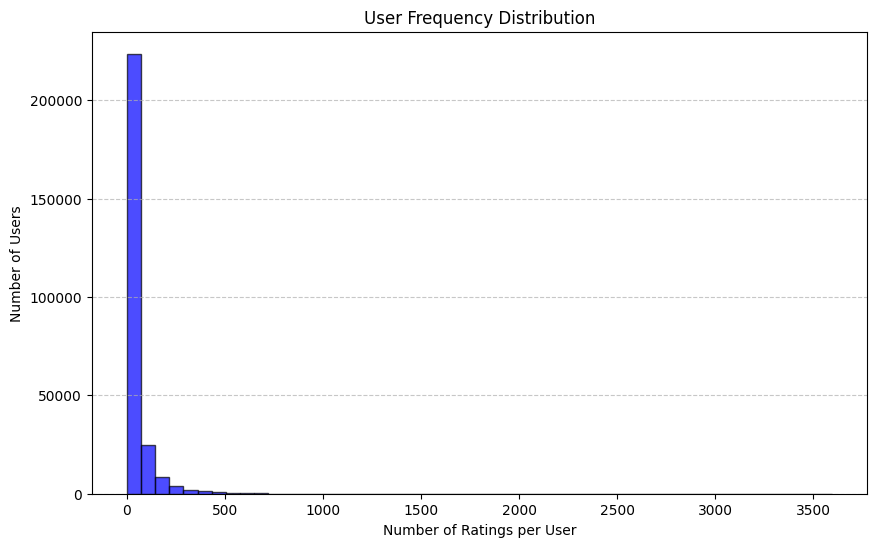

In [92]:
# Histrogram for userId on new_ratings_df

plt.figure(figsize=(10, 6))
plt.hist(user_freq, bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.title('User Frequency Distribution')
plt.xlabel('Number of Ratings per User')
plt.ylabel('Number of Users')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

- Above diagram shows that our data is highly skewed therefore our mean is very far from average frequency

In [93]:
no_of_user_rated_more_than_500_movie = len(user_freq[user_freq >= 500])
print(f"There are {no_of_user_rated_more_than_500_movie} no of users who rated more than 500 movies")

There are 1199 no of users who rated more than 500 movies


    Finding correct avarage rating count per user

In [94]:
required_user = new_ratings_df[new_ratings_df['userId'].isin(user_freq[user_freq < 500])] # this will give user list who rated less than 500

In [95]:
# we have eliminated the user's who rated more than 500 movies

In [96]:
# find frequencies
required_user_freq_map = required_user['movieId'].value_counts()

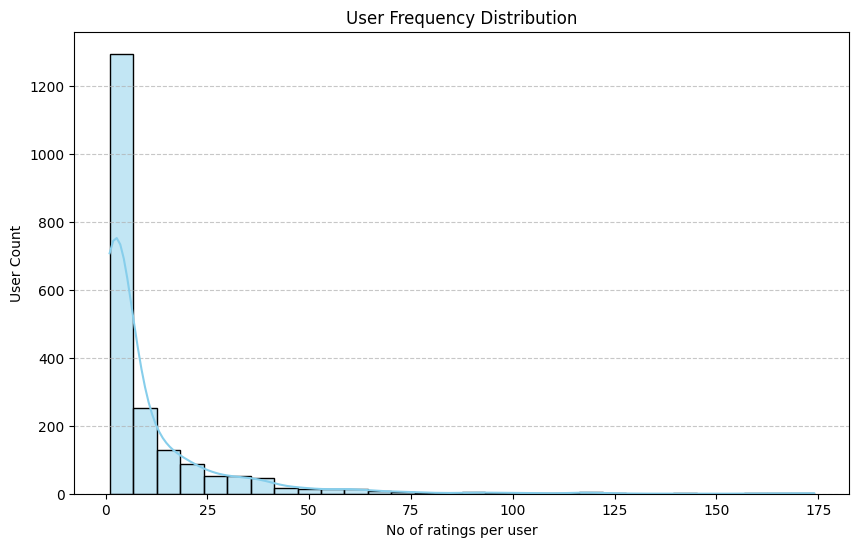

In [97]:
plt.figure(figsize=(10,6))

# draw a kde plot
sns.histplot(data = required_user_freq_map, bins=30, color='skyblue', kde=True)
plt.title("User Frequency Distribution")
plt.xlabel("No of ratings per user")
plt.ylabel("User Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [98]:
actual_average_vote_per_user = required_user_freq_map.mean()
print(f"Average ratings per user = {actual_average_vote_per_user}")

Average ratings per user = 10.478887232985594


    Conclusion : Our user distriution is highly skewed because of which initially, we are getting 43 as average rating per user which is wrong. Our correct avarage rating is 10.
    &
    There are 1199 user who rated more than 500 movies.

### Top 20 users who contributed a lot in this dataset

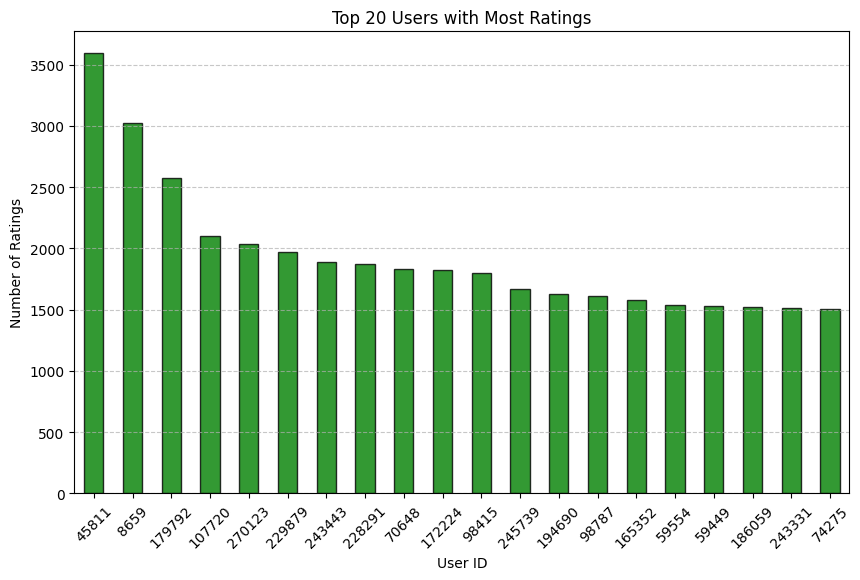

In [99]:
# top 20 users from series of user_freq
top_users = user_freq.head(20)

plt.figure(figsize=(10, 6))
top_users.plot(kind='bar', color='green', edgecolor='black', alpha=0.8)
plt.title('Top 20 Users with Most Ratings')
plt.xlabel('User ID')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

    Conclusion: above are the top 20 regular users which rated most of the movies

In [100]:
valid_users = len(user_freq[user_freq >= 20])
print(f"Total no of valid user rated less than 10 movies are {valid_users}.")

Total no of valid user rated less than 10 movies are 120180.


In [101]:
# Extract the valid users from new_ratings_df

# step1 : list the valid userId
valid_userId = user_freq[user_freq >= 20].index

filtered_rating_df = new_ratings_df[new_ratings_df['userId'].isin(valid_userId)]

filtered_rating_df.shape

(10221190, 4)

### Univariate analysis on movieId

    Analysing no of movies. Remove the movies who got less no of rating

In [102]:
movie_freq = filtered_rating_df['movieId'].value_counts()

In [103]:
max_movie_freq = movie_freq.max()
min_movie_freq = movie_freq.min()
average_no_of_rating_per_movie = movie_freq.mean()

In [104]:
print(
    f"Maximum no of rating to movie = {max_movie_freq}\nMinimum no of rating to the movie = {min_movie_freq}"
)
print(f"Average no of rating per movie = {average_rating_per_user}")

Maximum no of rating to movie = 72625
Minimum no of rating to the movie = 1
Average no of rating per movie = 43.00803634216692


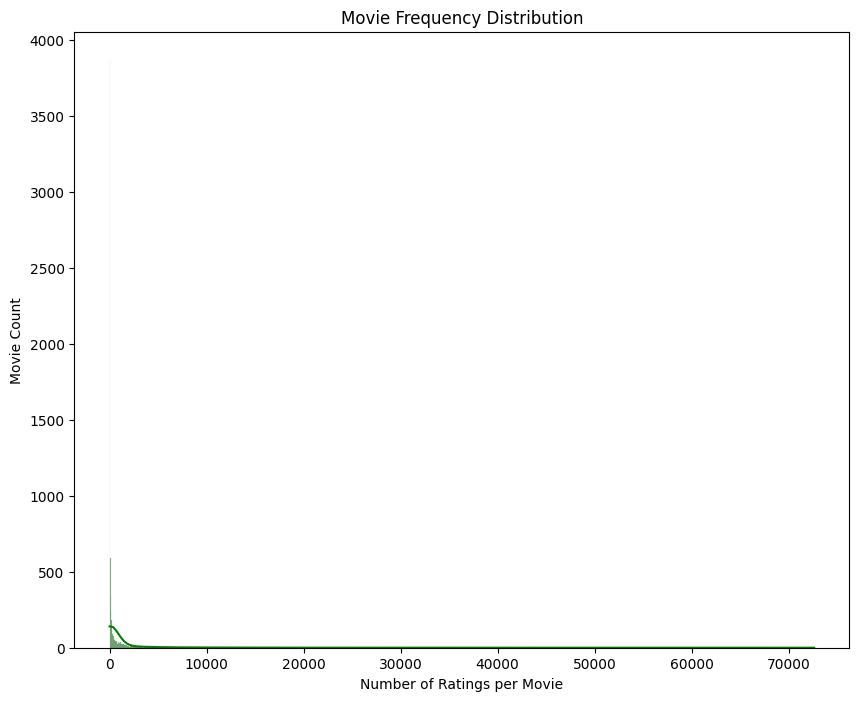

In [105]:
# let's draw histogram for movie to see its distribution

plt.figure(figsize=(10,8))

sns.histplot(data=movie_freq, kde=True, color='green', edgecolor='black')
plt.title("Movie Frequency Distribution")
plt.xlabel("Number of Ratings per Movie")
plt.ylabel("Movie Count")
plt.show()

    The diagram is clearly showing that many movies who are rated by one or two people.
    Let't try to remove all these

In [106]:
len(movie_freq[movie_freq < 10])

2237

In [107]:
total_movie = new_ratings_df['movieId'].nunique()

In [108]:
print(f"Total no of Movie = {total_movie}")

Total no of Movie = 7565


In [109]:
len(movie_freq[movie_freq >= 50])

3614

In [110]:
len(movie_freq[movie_freq == 1])

571

In [111]:
len(movie_freq[movie_freq <= 2])

1003

In [112]:
len(movie_freq[movie_freq <= 3])

1310

In [113]:
len(movie_freq[movie_freq <= 50])

3949

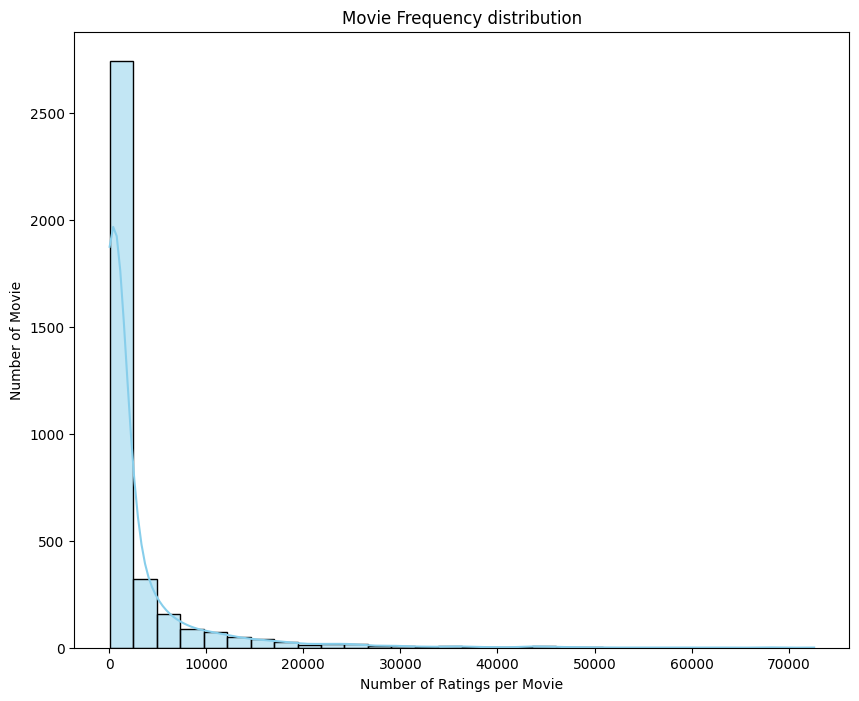

In [114]:
required_movies = movie_freq[movie_freq > 50]

plt.figure(figsize=(10, 8))

sns.histplot(data=required_movies, kde=True, bins=30, color='skyblue', edgecolor='black')
plt.title("Movie Frequency distribution")
plt.xlabel("Number of Ratings per Movie")
plt.ylabel("Number of Movie")
plt.show()

### Movies who got more than 20000 ratings

In [115]:
movie_20000 = len(movie_freq[movie_freq > 50])
print(f"Number of movies who got more than 20000 no of ratings by user are {movie_20000}")

Number of movies who got more than 20000 no of ratings by user are 3599


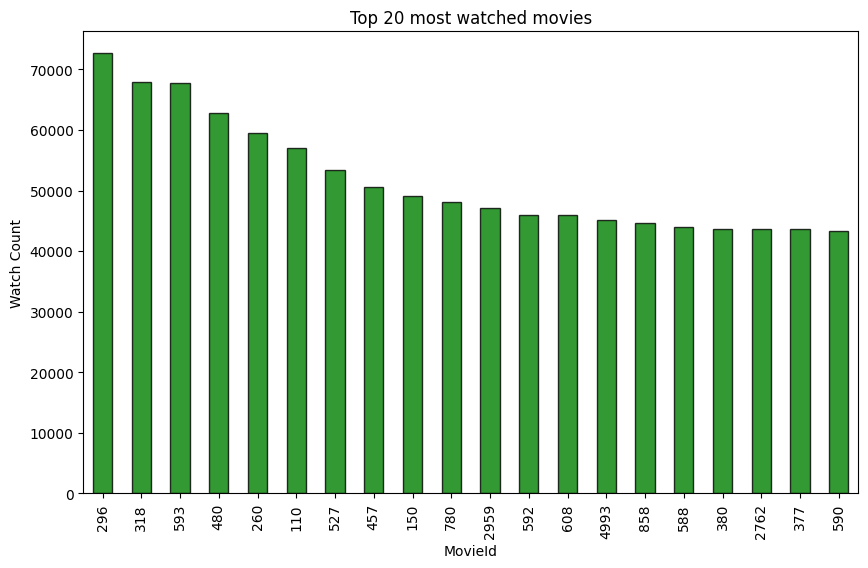

In [116]:
# top 20 movies who got highest no of votes
top_20_most_watched_movies = movie_freq.head(20)

plt.figure(figsize=(10,6))

top_20_most_watched_movies.plot(kind='bar', color='green', edgecolor='black', alpha=0.8)
plt.title("Top 20 most watched movies")
plt.xlabel("MovieId")
plt.ylabel("Watch Count")
plt.show()

    Extract movieId from filtered_rating_df

In [117]:
filtered_rating_df.shape

(10221190, 4)

In [118]:
filtered_rating_df.head()

,userId,movieId,rating,timestamp
59,4,223,4.0,1042668576
60,4,415,4.0,1042667925
61,4,648,4.0,1042674800
66,4,1422,4.0,1042674861
68,4,1597,3.0,1042674787


In [119]:
movie_freq_map = filtered_rating_df['movieId'].value_counts()
filtered_movie_map = movie_freq_map[movie_freq_map > 50] # we are taking those movies who got atleast 50 no of ratings

filtered_rating_df = filtered_rating_df[filtered_rating_df['movieId'].isin(filtered_movie_map)]

filtered_rating_df.shape

(4225682, 4)

## EDA in keywords/Geners/Casts

# **Modeling**

We have processed the ratings and keywords and store it in new_ratings_df. we have to now create a model to understand the pattern and using this we will build our recommendation system.

# Recommendation System

A **Recommendation System** is a machine learning model designed to suggest items to users based on their preferences, interests, ratings and item similarity. It helps reduce the time users spend manually for searching the items of his interest. Recommendation systems are widely used in various domains like e-commerce, streaming platforms, and social media.
Recommendation System mainly categories into 3 parts.
1. **Popularity-Based Recommendation**
2. **Content-Based Recommendation**
3. **Collaborative Filtering**

## 1. **Popularity Based Recommendation:**
This type of recommendation system suggests items that are trending or popular among all users, irrespective of their individual preferences.
For example:

- The trending section on Netflix recommends shows or movies that are widely viewed by other users.
- The "Trending Now" section on X (formerly Twitter) highlights trending posts or topics.
    
## 2. **Content based filtering**:
This Model used the feature of the currently visited or liked item by the user like if a user like a movie of genre action and comedy. Model will recommmend him similar movie containing same tags (action and comedy). To do show we use vectorization technique(eg. TF-IDF, count_vectorizer) and cosine similarity.
## 3. **Collaborative filtering**:
It used the idea of similarity in preference and co-occurence of the item.
It is called collaborative because it used collabortion of various user and items to suggest items.
Collaborative Filtering is further divided into:

1. **Neighbourhood based approach**
2. **Model Based Approaches**

### 3.1 **Neighbourhood based approach:**
This method identifies users or items with similar preferences.
- **User-Based Filtering:**

    - Finds users (neighbors) with similar preferences or behavior.
    - Predicts how likely a user is to like an item based on the preferences of similar users.
    - Example: If User A and User B have rated the same movies highly, a movie liked by User A but not yet watched by User B may be recommended to User B.

- **Item-Based Filtering:**

    - Focuses on the similarity between items based on user interactions.
    - Uses a co-occurrence matrix that records how often items are interacted with together.
    - Items are ranked and sorted based on similarity scores.
    - Example: If a user liked Movie A and Movie B, a new user liking Movie A might also be recommended Movie B.
User and item based filtering both uses nearest neighbour learning algorithm(**KNN**). As we know KNN is a run time algorithm and in any instant there is a million or billion of items and users, it will become memory consuming and takes lots of time. so during the run time, this is not a good approach in recommendation system.
User and Item based filtering both are classification method.

### 3.2 **Model Based Approach**
These approaches use advanced algorithms to build more scalable and accurate recommendation systems.
i) **Clustering-Based Filtering**
ii) **Matrix Factorization**
iii) **Deep Learning-Based Approaches**

In [120]:
# We can use collaborative filtering in both user rating and content. First we will machine learning on ratings then on content.
# Then we will apply deep learning in both ratings and content. Then we will try to make a hybrid recommendation system, we will make an 
# order that what should we apply first to recommend.

# Let's first make a user-movie matrix which contain rating and apply machine learning and deep learning.

In [121]:
df = filtered_rating_df[0:200000]

In [122]:
df.head()

,userId,movieId,rating,timestamp
59,4,223,4.0,1042668576
60,4,415,4.0,1042667925
61,4,648,4.0,1042674800
71,4,1645,4.0,1042674787
77,4,2355,4.0,1042668559


In [123]:
df.drop(columns=['timestamp'], inplace=True)

/tmp/ipykernel_2086963/489683870.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['timestamp'], inplace=True)


In [124]:
df['userId'].is_monotonic_increasing

True

In [125]:
df.duplicated().sum()

np.int64(0)

In [143]:
rows = df['userId'].unique()
cols = df['movieId'].unique()

# user_ratings_df = pd.DataFrame(index = rows, columns=cols, data=0.0)

In [163]:
user_ratings_df = df.pivot_table(index='userId', columns='movieId', values='rating', fill_value=0) 

In [164]:
user_ratings_df.shape

(5666, 845)

In [165]:
user_ratings_df.head()

movieId,55,58,59,62,63,64,65,66,67,68,...,6396,6466,6967,7249,7979,8592,8836,8873,26325,45952
userId,,,,,,,,,,,,,,,,,,,,,
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [166]:
user_ratings_df.loc[4, 223]

np.float64(4.0)

In [ ]:
# for _, row in df.iterrows():
#     user = row['userId']
#     movie = row['movieId']
#     rating = row['rating']
#     user_ratings_df.loc[user, movie] = rating

In [ ]:
# user_ratings_df = user_ratings_df.fillna(0.0)

In [ ]:
# user_ratings_df.head()

In [ ]:
# user_ratings_df.describe()

### For modeling we will use cosine similarity matrix( we can also use Euclidian distance or Manhattan distance).
    
### Formulas:
- **Euclidean Distance** = sqrt(x^2 + y^2)

- **Manhattan Distance** = |x| + |y|
      


In [167]:
similarity_score = cosine_similarity(user_ratings_df)

In [168]:
similarity_score.shape

(5666, 5666)

In [169]:
similarity_score

array([[1.        , 0.        , 0.        , ..., 0.        , 0.11489306,
        0.10788885],
       [0.        , 1.        , 0.2900074 , ..., 0.        , 0.08499449,
        0.06065787],
       [0.        , 0.2900074 , 1.        , ..., 0.04497577, 0.19454247,
        0.09917056],
       ...,
       [0.        , 0.        , 0.04497577, ..., 1.        , 0.31264545,
        0.29250263],
       [0.11489306, 0.08499449, 0.19454247, ..., 0.31264545, 1.        ,
        0.33853662],
       [0.10788885, 0.06065787, 0.09917056, ..., 0.29250263, 0.33853662,
        1.        ]])

In [172]:
## Store similarity score to make recommendation system

pickle.dump(user_ratings_df, open('../backend/datasets/collaborative_cosine_movie_data.pkl', 'wb'))
pickle.dump(similarity_score, open('../backend/datasets/collaborative_cosine_similarity.pkl', 'wb'))